# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.metrics import jaccard_score
from shapely.geometry import Polygon
from collections import defaultdict
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.utils.data as data
from tqdm.notebook import tqdm
from datetime import datetime
import imageio.v2 as imageio
import torch.nn as nn
from glob import glob
from PIL import Image
import numpy as np
import random
import shutil
import torch
import timm
import sys
import os

c:\programmers\envs\vit\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [4]:
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"
torch.cuda.empty_cache()
def clean_gpu_memory():
    """
    Clears all GPU memory and ensures no tensors occupy GPU memory.
    """
    # Clear cache to free unused memory
    torch.cuda.empty_cache()
    print("CUDA cache cleared.")

    # Collect garbage to remove unreferenced tensors
    torch.cuda.ipc_collect()
    print("CUDA inter-process caches collected.")

    # Sync CUDA to make sure all operations are complete
    torch.cuda.synchronize()
    print("CUDA operations synchronized.")

    # Confirm memory usage after cleanup
    for device in range(torch.cuda.device_count()):
        memory_allocated = torch.cuda.memory_allocated(device)
        memory_reserved = torch.cuda.memory_reserved(device)
        print(f"GPU {device}: Allocated memory: {memory_allocated / 1e6:.2f} MB, Reserved memory: {memory_reserved / 1e6:.2f} MB")


clean_gpu_memory()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

CUDA cache cleared.
CUDA inter-process caches collected.
CUDA operations synchronized.
GPU 0: Allocated memory: 0.00 MB, Reserved memory: 0.00 MB


# Pre-processing

In [5]:
datatime_code = datetime.now().strftime('%Y%m%d%H%M%S')
name_model = f"Just_Unet_{datatime_code}"
results_path = f"F:/CNN_LSTM/{name_model}/"

log_pth_file = "F:/CNN_LSTM/log_file/"
os.makedirs(results_path, exist_ok=True)
os.makedirs(log_pth_file, exist_ok=True)

In [6]:
BASE_DIR = "VH"

# TROCAR AQUI
train_imgs = glob(os.path.join(BASE_DIR, "train/amostras/*tiff"))
train_masks = glob(os.path.join(BASE_DIR, "train/classes/*tiff"))

val_imgs = glob(os.path.join(BASE_DIR, "val/amostras/*tiff"))
val_masks = glob(os.path.join(BASE_DIR, "val/classes/*tiff"))

test_imgs = glob(os.path.join(BASE_DIR, "test/amostras/*tiff"))
test_masks = glob(os.path.join(BASE_DIR, "test/classes/*tiff"))

print(f"The shape of train_imgs is {imageio.imread(train_imgs[0]).shape}")
print(f"The shape of train_masks is {imageio.imread(train_masks[0]).shape}")

The shape of train_imgs is (512, 512, 11)
The shape of train_masks is (512, 512)


# DataLoader

In [7]:
from spatial_time_pckg import custom_dataset

In [8]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip()
])

# Train dataset with the same transformations for both images and masks
train_dataset = custom_dataset.Dataset2D(
    train_imgs,
    train_masks,
    transform=transform,
    transform_label=transform)

# Validation and test datasets only convert to tensors
val_dataset = custom_dataset.Dataset2D(
    val_imgs,
    val_masks,
    transform=transforms.ToTensor(),
    transform_label=None)

test_dataset = custom_dataset.Dataset2D(
    test_imgs,
    test_masks,
    transform=transforms.ToTensor(),
    transform_label=None)

In [9]:
from torch.utils.data import DataLoader

# Define batch sizes
BATCH_SIZE_TRAIN = 16
BATCH_SIZE_VALID = 16
BATCH_SIZE_TEST = 16

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True, num_workers=0)
valid_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE_VALID, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE_TEST, shuffle=False, num_workers=0)

In [10]:
# Verify batch
for images, labels in train_loader:
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
    break

Image batch shape: torch.Size([16, 11, 512, 512])
Label batch shape: torch.Size([16, 512, 512])


# Model

In [11]:
from spatial_time_pckg.models import *
from spatial_time_pckg.training import TrainEpoch, ValidEpoch
from spatial_time_pckg.metrics import *
from spatial_time_pckg.losses import *

In [12]:
from segmentation_models_pytorch.utils.imports import *
# Define model parameters
ENCODER = 'resnet101' #'efficientnet-b7' #resnet101 #efficientnet-b7 #resnext101_32x16d
ENCODER_WEIGHTS = 'imagenet' #'instagram'
CLASSES = ['c0'] # For binary segmentation, only one class is needed
ACTIVATION = "sigmoid" #'softmax' #None #'softmax' #'sigmoid' if len(CLASSES) == 1 else 'softmax'

# Initialize the U-Net model with the specified encoder
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
    in_channels=11
    #decoder_atrous_rates=(1,2,4) # DLV3PLus
)

In [13]:
# Hyperparameters
LEARNING_RATE = 0.001
EPOCHS = 100
# Define the loss function (DiceLoss or CrossEntropyLoss)
loss = smp.utils.losses.DiceLoss()  # Change to CrossEntropyLoss() if needed
#loss = smp.utils.losses.CrossEntropyLoss()

# Define the metric for evaluation. IoU (Intersection over Union) is a standard metric for segmentation.
#metrics = [smp.utils.metrics.mIoU()]
metrics = [smp.utils.metrics.IoU()]

# Initialize the optimizer
opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

scheduler = None
# Training loop setup using SMP utilities
train_epoch = TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=opt,
    device=DEVICE,
    scheduler=scheduler)

valid_epoch = ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE)


## Training Loop

In [14]:
def convert_seconds(seconds, EPOCHS):
    seconds = seconds * EPOCHS
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    seconds = seconds % 60
    print(f"Time to finish epochs: {hours:.1f} hours, {minutes:.2f} minutes, {seconds:.2f} seconds")

In [15]:
import time

# Initialize the minimum dice loss and max IoU for saving the best model
max_iou = 0

# Number of epochs to train

mean = np.array([])

# Run the training loop for the specified number of epochs
for epoch in range(EPOCHS):
    start = time.time()

    print(f'\nEpoch: {epoch + 1}/{EPOCHS}')
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    end = time.time()
    mean = np.append(mean, end - start)
    convert_seconds(mean.mean(), EPOCHS - (epoch + 1))
    # If validation IoU improves, save the model's state dictionary
    if max_iou < valid_logs['iou_score']:
        max_iou = valid_logs['iou_score']
        # torch.save(model.state_dict(), 'p16_h1024_hl8_ah128.pth')
        torch.save(model.state_dict(), f'{log_pth_file}/training_model_{datatime_code}.pth')
        print('Model saved!')
    if scheduler is not None:
        scheduler.step(valid_logs['iou_score'])


Epoch: 1/100
valid: 100%|██████████| 10/10 [01:37<00:00,  9.74s/it, DiceLoss - 0.562, iou_score - 0.2844]
Time to finish epochs: 32.0 hours, 3.00 minutes, 42.71 seconds
Model saved!

Epoch: 2/100
valid: 100%|██████████| 10/10 [01:30<00:00,  9.09s/it, DiceLoss - 0.547, iou_score - 0.2978]
Time to finish epochs: 30.0 hours, 59.00 minutes, 10.37 seconds
Model saved!

Epoch: 3/100
valid: 100%|██████████| 10/10 [01:30<00:00,  9.08s/it, DiceLoss - 0.3606, iou_score - 0.4817]
Time to finish epochs: 30.0 hours, 13.00 minutes, 42.52 seconds
Model saved!

Epoch: 4/100
valid: 100%|██████████| 10/10 [01:30<00:00,  9.09s/it, DiceLoss - 0.1916, iou_score - 0.689]
Time to finish epochs: 29.0 hours, 42.00 minutes, 8.97 seconds
Model saved!

Epoch: 5/100
valid: 100%|██████████| 10/10 [01:31<00:00,  9.10s/it, DiceLoss - 0.1923, iou_score - 0.683]
Time to finish epochs: 29.0 hours, 16.00 minutes, 11.83 seconds

Epoch: 6/100
valid: 100%|██████████| 10/10 [01:31<00:00,  9.14s/it, DiceLoss - 0.3602, iou_sc

In [16]:
print(f"Best IoU = {max_iou}")

Best IoU = 0.8497514128684998


## Metrics

In [18]:
model.load_state_dict(torch.load(f'{log_pth_file}/training_model_{datatime_code}.pth'))
model.to('cuda')

C:\Users\Lucas Lessa\AppData\Local\Temp\ipykernel_19768\1949279449.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{log_pth_file}/trai

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(11, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
     

In [19]:
model.to(DEVICE)

metrics = evaluate_model(model, test_loader, DEVICE)
print(f"IoU: {metrics['IoU']}")
print(f"Precision: {metrics['Precision']}")
print(f"Recall: {metrics['Recall']}")
print(f"F-score: {metrics['F-score']}")
print(f"Accuracy: {metrics['Accuracy']}")

IoU: 0.8751656850778389
Precision: 0.9497753935382502
Recall: 0.917431843878089
F-score: 0.9332593238686948
Accuracy: 0.9747951507568359


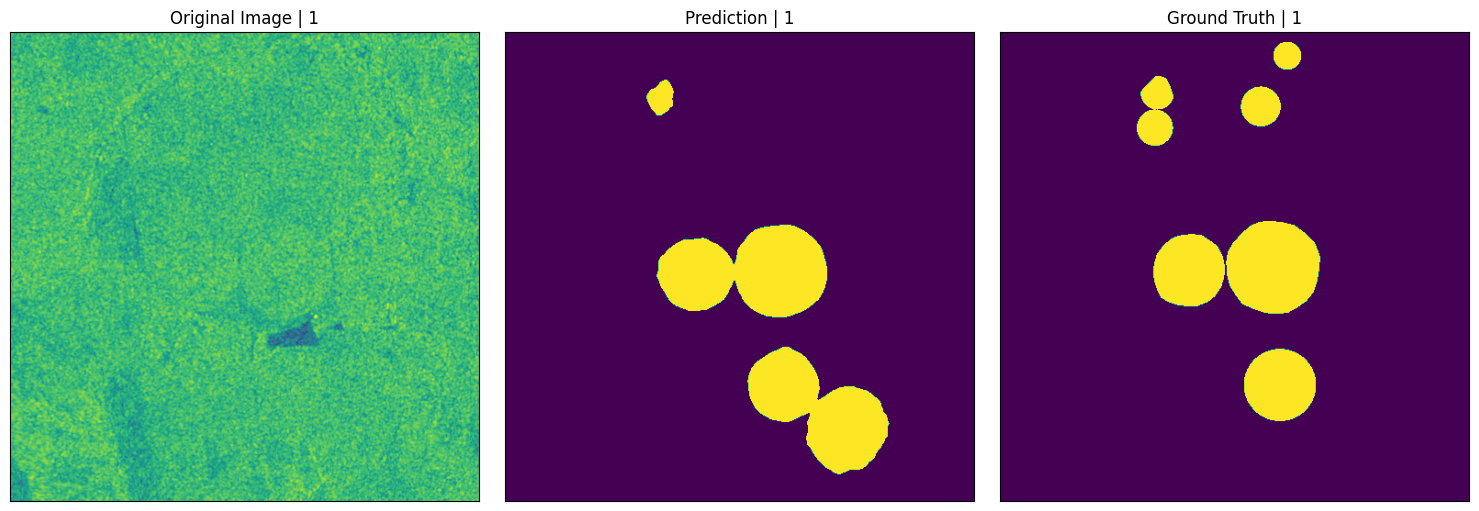

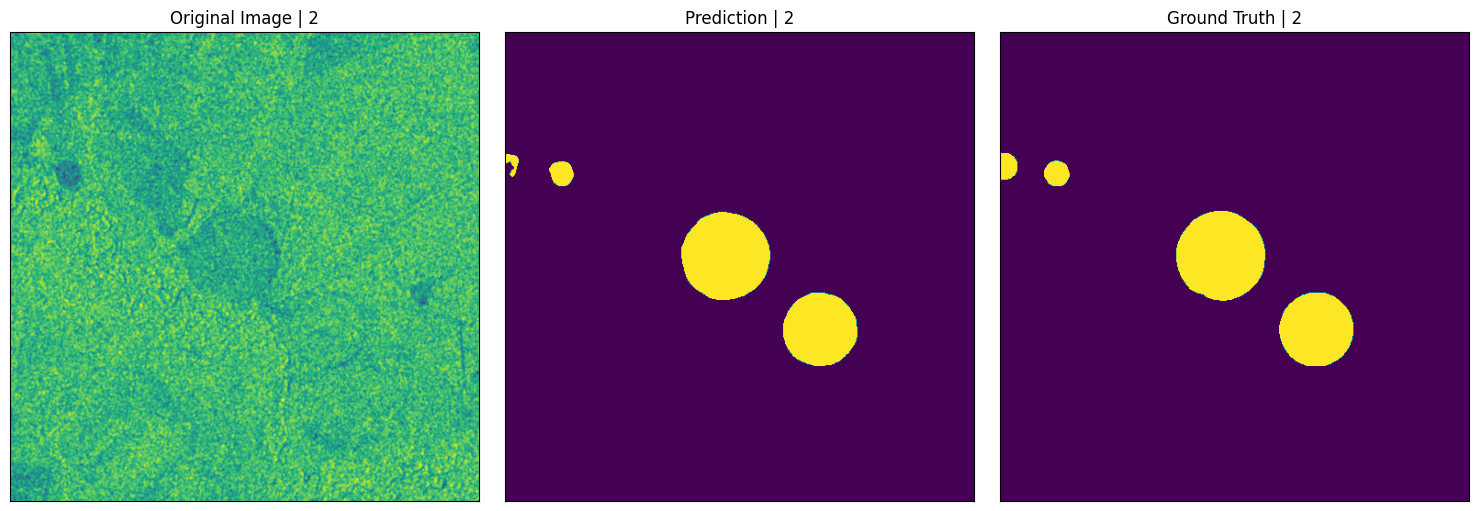

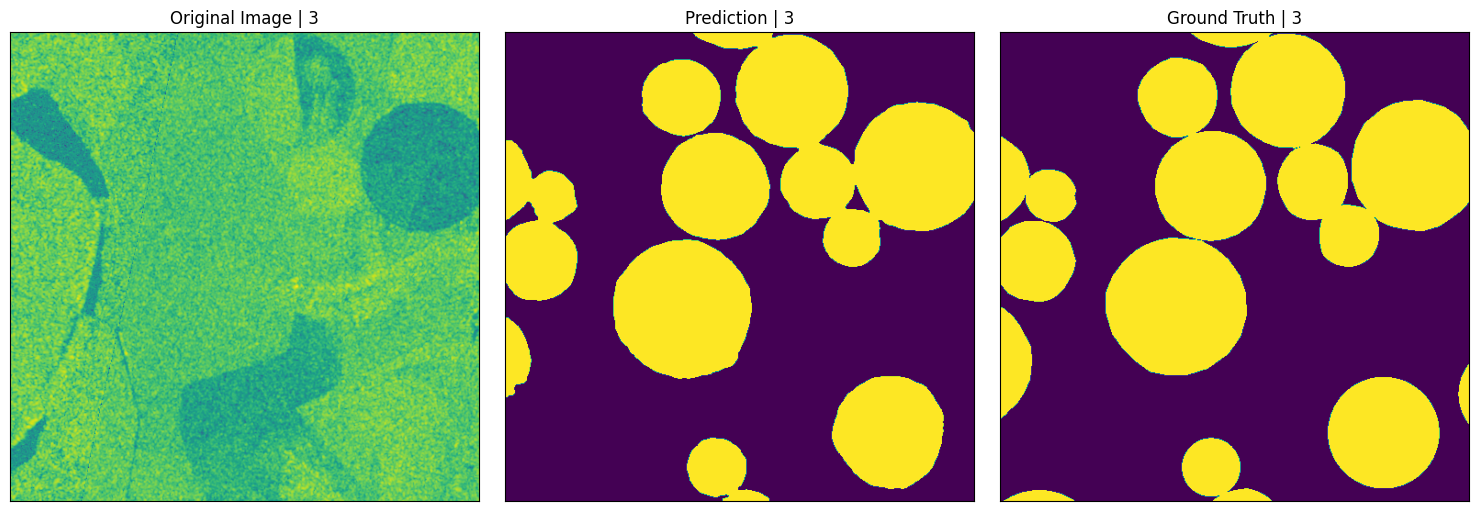

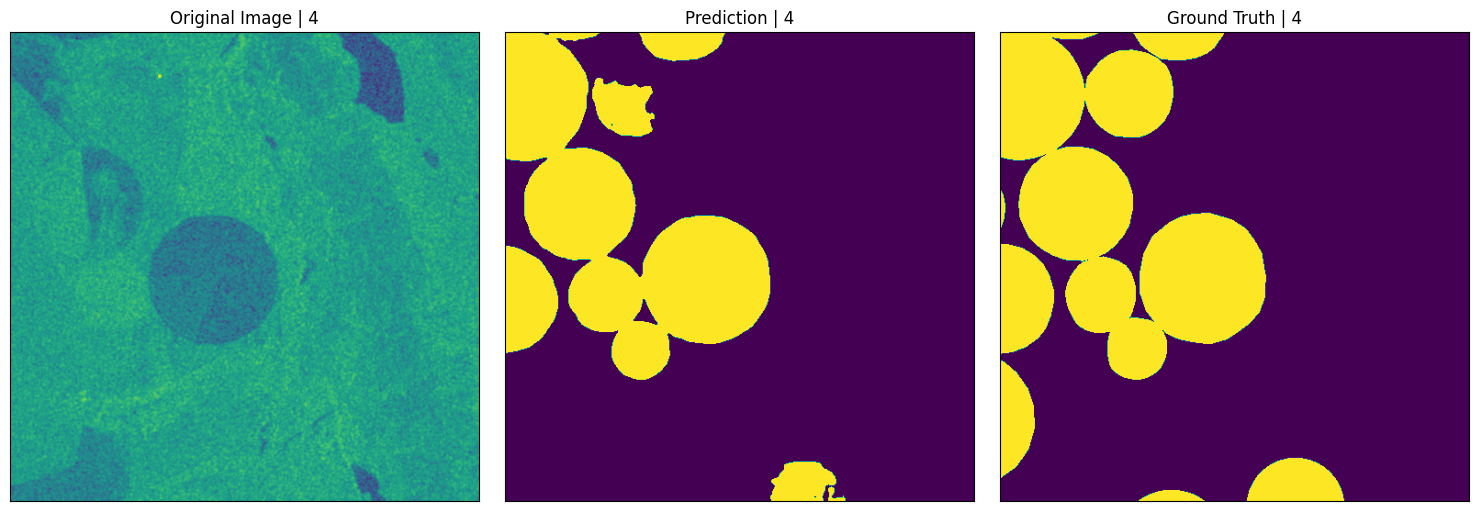

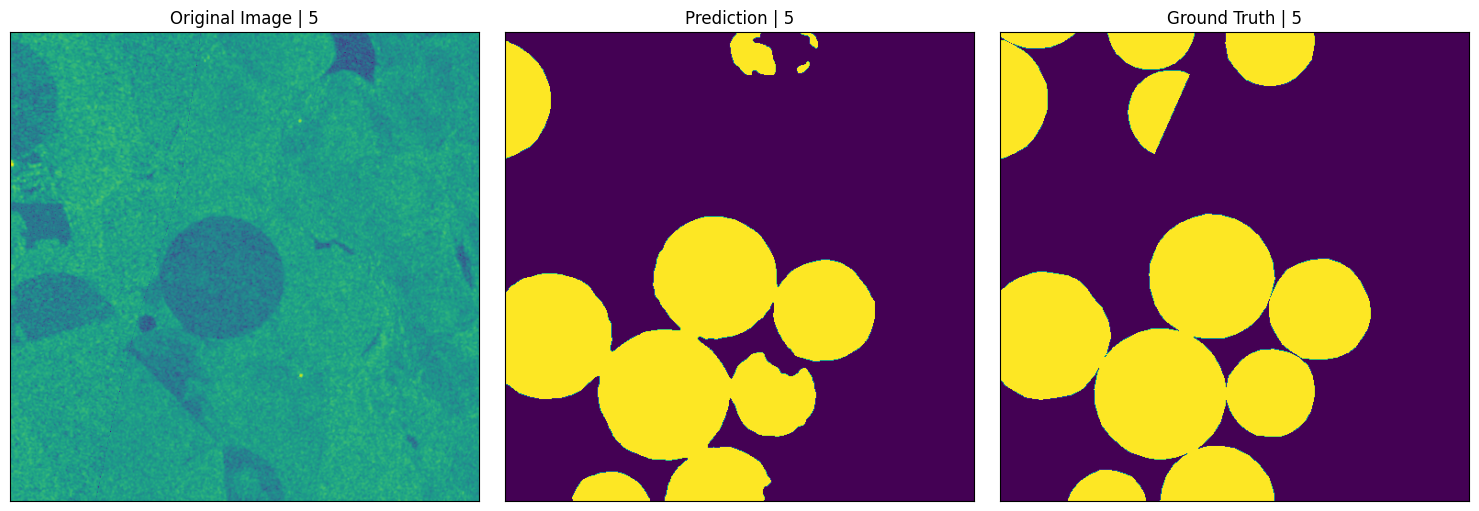

In [20]:
visualize_predictions(model, valid_loader, DEVICE, num_images=5, binary=True, threshold=0.5)

# Save informations and results

In [22]:
results_path

'F:/CNN_LSTM/Just_Unet_20241208101130/'

In [24]:
train_logs

{'DiceLoss': np.float32(0.050984666), 'iou_score': np.float32(0.9033343)}

In [25]:
print(f"Saving results in {results_path}")

info_model = {
    "Dropout": [None],
    "NlayersFreeze": [None],
    "Learn_Rate": [LEARNING_RATE],
    "NumEpochs": [EPOCHS],
    "Best_IoU": [max_iou]
    }

df_info_model = pd.DataFrame(info_model, index=[0])
df_history = pd.DataFrame(valid_logs, index=[0])

# notebook_path = 'C:/Users/Lucas Lessa/Documents/Spatial_and_Time_Model/CNN-LSTM Simples.ipynb'
# shutil.copy(notebook_path, f'{results_path}cod2_used2train.ipynb')


with pd.ExcelWriter(f'{results_path}/info_data.xlsx', engine='openpyxl') as writer:
    # Write each DataFrame to a different sheet
    df_info_model.to_excel(writer, sheet_name='Informações do Modelo', index=False)
    df_history.to_excel(writer, sheet_name='Dados de treinamento', index=False)

shutil.copy2(f'{log_pth_file}/training_model_{datatime_code}.pth', f'{results_path}weights.pth')

print("Excel file with multiple sheets created successfully!")



Saving results in F:/CNN_LSTM/Just_Unet_20241208101130/
Excel file with multiple sheets created successfully!


In [ ]:
import shutil
import os

def save_current_notebook(notebook_name, results_path):
    """
    Salva o notebook atual na pasta de resultados.

    Args:
        notebook_name (str): Nome do notebook atual (incluindo extensão .ipynb).
        results_path (str): Caminho onde o notebook será salvo.
    """
    if not os.path.exists(results_path):
        os.makedirs(results_path)

    # Caminho completo do notebook atual
    notebook_path = os.path.abspath(notebook_name)

    # Copiar o notebook para o diretório de resultados
    try:
        shutil.copy2(notebook_path, os.path.join(results_path, 'notebook_used_to_train.ipynb'))
        print(f"Notebook salvo com sucesso em {results_path}")
    except Exception as e:
        print(f"Erro ao salvar o notebook: {e}")

# Nome do notebook atual e diretório de resultados
notebook_name = 'Just_Unet.ipynb'  # Substitua pelo nome do notebook atual


# Salvar o notebook
save_current_notebook(notebook_name, results_path)


Notebook salvo com sucesso em F:/CNN_LSTM/Just_Unet_20241208101130/


: 